In [1]:
!git clone https://github.com/Kemsekov/kemsekov_torch
!cd kemsekov_torch && git pull

fatal: destination path 'kemsekov_torch' already exists and is not an empty directory.
Already up to date.


In [2]:
#download dataset
import kagglehub

path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
print("Path to dataset files:", path)

Path to dataset files: /home/vlad/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


In [3]:
# path to folder with images
import os
data_dir=os.path.join(path,'Image')
mask_dir=os.path.join(path,'Mask')


In [4]:
# define dataset to load data
import os
import torch
import PIL.Image as Image

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self,images_path,labels_path,transform = None,cache=True):
        """
        images_path: path to images
        labels_path: path to labels
        transform: Callable[Image,Images] -> Tuple[Tensor,Tensor] transform both image and label
        """
        super().__init__()
        self.images = {f.split('.')[0]:os.path.join(images_path,f) for f in os.listdir(images_path)}
        self.labels = {f.split('.')[0]:os.path.join(labels_path,f) for f in os.listdir(labels_path)}
        self.keys = list(self.images.keys())
        self.cache = cache
        self.cached_images = {}
        
        if transform is None:
            self.transform = lambda x,y: (x,y)
        else:
            self.transform = transform
    def __len__(self):
        return len(self.keys)
        
    def __getitem__(self,index):
        if self.cache and index in self.cached_images:
            return self.cached_images[index]
        key = self.keys[index]
        im = self.images[key]
        lb = self.labels[key]
        im,lb = Image.open(im),Image.open(lb)
        im,lb = self.transform(im,lb)
        self.cached_images[index]=(im,lb)
        
        return im,lb

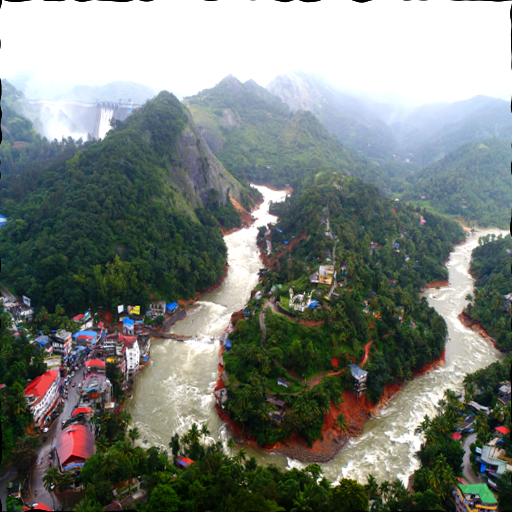

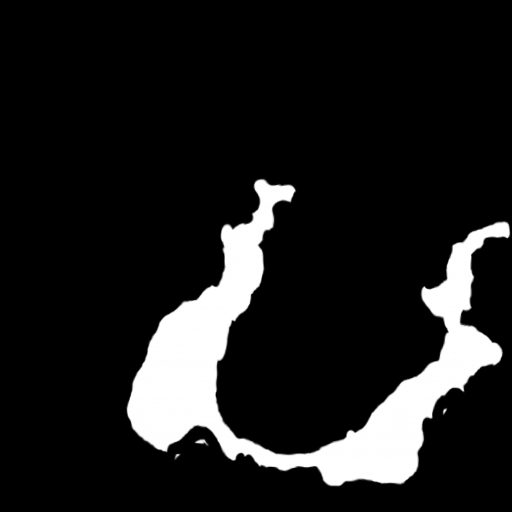

In [ ]:
import torch
import torchvision.transforms as T

TRAIN_IMAGE_SIZE=512

# gpu inputs transform to augment data
def transform(image,label):
    if image.shape[1]==1:
        image=image[:,[0,0,0]]
    # morph shapes of image and mask
    morph = T.Compose([
        T.RandomHorizontalFlip(),
        T.ElasticTransform(),
    ])
    # jit color of input image
    color = T.ColorJitter(0.5,0.5,0.5,0.)
    
    image=color(image)
    cat = torch.concat([image,label],1)
    cat = morph(cat)
    image = cat[:,:image.shape[1]]
    label = cat[:,image.shape[1]:]
    return image,label

#cpu transforms to convert input images to tensors
def resize_image(x):
    if x.shape[0]==1:
        x=x[[0,0,0]]
    return x[:3]
image_t = T.Compose([
    T.ToTensor(),
    T.Resize((TRAIN_IMAGE_SIZE,TRAIN_IMAGE_SIZE)),
    T.Lambda(resize_image)
])
mask_t = T.Compose([
    image_t,
    T.Lambda(lambda x: x[[0]])
])

dataset = SegmentationDataset(data_dir,mask_dir,transform=lambda x,y : (image_t(x),mask_t(y)))

a,b = dataset[12]
a,b = [v[0] for v in transform(a[None,:],b[None,:])]

display(T.ToPILImage()(a))
display(T.ToPILImage()(b))
# display(T.ToPILImage()(b[0]))
# display(T.ToPILImage()(b[1]))
# display(T.ToPILImage()(b[2]))
# display(T.ToPILImage()(b[3]))

In [6]:
# split dataset and create loaders
from kemsekov_torch.train import split_dataset

train_dataset,test_dataset,train_loader, test_loader = split_dataset(
    dataset,
    test_size=0.1,
    batch_size=4,
    num_workers=4,
    prefetch_factor=2
)

print("train size",len(train_dataset))
print("test size",len(test_dataset))

train size 261
test size 29


In [7]:
# create a small unet model
from kemsekov_torch.resunet import ResidualUnet
from kemsekov_torch.common_modules import module_params_count
model = ResidualUnet(
    in_channels=3,
    out_channels=1,
    # intermediate channels that define how unet expands and collapse dimensions
    channels=[16,32,64,128,256],
    # Dilations of convolutions at some layers. Helps to expand receptive field of the model.
    dilations=[1,1,1,[1,1,2],[1,1,2]]
)
x = torch.randn((8,3,256,256))
print(model(x).shape)

torch.Size([8, 1, 256, 256])


In [8]:
from kemsekov_torch.train import train
from kemsekov_torch.metrics import iou_metric,r2_score
import gc
gc.collect()
torch.cuda.empty_cache()
bce = torch.nn.BCEWithLogitsLoss()
def compute_loss_and_metric(model,batch):
    # get batch
    image,labels = batch
    image,labels=transform(image,labels)
    
    pred = model(image)
    loss = bce(pred,labels)
    pred = pred.sigmoid()
    return loss,{
        'iou':iou_metric(pred,labels),
        'r2':r2_score(pred,labels)
    }

_ = train(
    model,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    'runs/segmentation',
    'runs/segmentation/last',
    accelerate_args={
        # use mixed precision to reduce memory usage
        'mixed_precision':'bf16',
        # compile model to train it faster
        'dynamo_backend':'inductor',
    },
    checkpoints_count=1,
    save_on_metric_improve=['iou'],
    num_epochs=100,
)

Total model parameters 3.18 M
loaded training state from runs/segmentation/last/state
trying to capture model architecture...
Saved model architecture at runs/segmentation/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 6/100


train 0: 100%|██████████| 66/66 [01:15<00:00,  1.15s/it, iou=0.7445, loss=0.3452, r2=0.5830]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.49747 | 0.54184 |
| iou  | 0.5537  | 0.5012  |
|  r2  | 0.2821  | 0.1256  |
+------+---------+---------+

Epoch 7/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.76it/s, iou=0.7340, loss=0.3537, r2=0.5745]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.48957 | 0.5284 |
| iou  | 0.5574  | 0.5343 |
|  r2  | 0.2970  | 0.1342 |
+------+---------+--------+
saved epoch-7

Epoch 8/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.76it/s, iou=0.6747, loss=0.3864, r2=0.5047]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.48351 | 0.50843 |
| iou  | 0.5543  | 0.5452  |
|  r2  | 0.3075  | 0.1827  |
+------+---------+---------+
saved epoch-8

Epoch 9/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.77it/s, iou=0.7524, loss=0.3315, r2=0.6060]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.48295 | 0.52888 |
| iou  | 0.5666  | 0.4917  |
|  r2  | 0.3086  | 0.1477  |
+------+---------+---------+

Epoch 10/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.67it/s, iou=0.7278, loss=0.3540, r2=0.5747]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.47778 | 0.50854 |
| iou  | 0.5644  | 0.5478  |
|  r2  | 0.3143  | 0.1798  |
+------+---------+---------+
saved epoch-10

Epoch 11/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.34it/s, iou=0.7487, loss=0.3422, r2=0.5967]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.47219 | 0.52749 |
| iou  | 0.5713  | 0.5174  |
|  r2  | 0.3256  | 0.1628  |
+------+---------+---------+

Epoch 12/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.06it/s, iou=0.7447, loss=0.3162, r2=0.6254]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.46393 | 0.49919 |
| iou  | 0.5749  | 0.5038  |
|  r2  | 0.3406  | 0.2179  |
+------+---------+---------+

Epoch 13/100


train 0: 100%|██████████| 66/66 [00:06<00:00, 10.04it/s, iou=0.7356, loss=0.3426, r2=0.5905]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.45697 | 0.49135 |
| iou  | 0.5681  | 0.5380  |
|  r2  | 0.3539  | 0.2097  |
+------+---------+---------+

Epoch 14/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.93it/s, iou=0.7444, loss=0.3234, r2=0.6164]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.45363 | 0.54222 |
| iou  | 0.5729  | 0.5176  |
|  r2  | 0.3568  | 0.0779  |
+------+---------+---------+

Epoch 15/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.16it/s, iou=0.7311, loss=0.3228, r2=0.6042]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.45062 | 0.49853 |
| iou  | 0.5783  | 0.5514  |
|  r2  | 0.3649  | 0.1659  |
+------+---------+---------+
saved epoch-15

Epoch 16/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.93it/s, iou=0.7553, loss=0.2935, r2=0.6605]


+------+--------+--------+
|      | Train  |  Test  |
+------+--------+--------+
| loss | 0.4466 | 0.471  |
| iou  | 0.5801 | 0.5632 |
|  r2  | 0.3705 | 0.2431 |
+------+--------+--------+
saved epoch-16

Epoch 17/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.06it/s, iou=0.7795, loss=0.2653, r2=0.6971]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.42111 | 0.49096 |
| iou  | 0.5979  | 0.5429  |
|  r2  | 0.4151  | 0.1792  |
+------+---------+---------+

Epoch 18/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.22it/s, iou=0.7712, loss=0.2601, r2=0.7021]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.41328 | 0.42645 |
| iou  | 0.6026  | 0.5657  |
|  r2  | 0.4276  | 0.3340  |
+------+---------+---------+
saved epoch-18

Epoch 19/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.06it/s, iou=0.7698, loss=0.2672, r2=0.6919]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.40589 | 0.4292 |
| iou  | 0.6207  | 0.5715 |
|  r2  | 0.4380  | 0.3235 |
+------+---------+--------+
saved epoch-19

Epoch 20/100


train 0: 100%|██████████| 66/66 [00:06<00:00,  9.73it/s, iou=0.8170, loss=0.2307, r2=0.7481]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.38717 | 0.44821 |
| iou  | 0.6304  | 0.5730  |
|  r2  | 0.4689  | 0.2927  |
+------+---------+---------+
saved epoch-20

Epoch 21/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.69it/s, iou=0.7833, loss=0.2543, r2=0.7123]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.38723 | 0.4049 |
| iou  | 0.6334  | 0.5834 |
|  r2  | 0.4713  | 0.3727 |
+------+---------+--------+
saved epoch-21

Epoch 22/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.81it/s, iou=0.7983, loss=0.2391, r2=0.7359]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.38148 | 0.42284 |
| iou  | 0.6433  | 0.5899  |
|  r2  | 0.4798  | 0.3530  |
+------+---------+---------+
saved epoch-22

Epoch 23/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.75it/s, iou=0.8026, loss=0.2249, r2=0.7512]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.36849 | 0.38037 |
| iou  | 0.6574  | 0.6011  |
|  r2  | 0.5059  | 0.4204  |
+------+---------+---------+
saved epoch-23

Epoch 24/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.82it/s, iou=0.7353, loss=0.2639, r2=0.6932]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.36069 | 0.37926 |
| iou  | 0.6595  | 0.5799  |
|  r2  | 0.5192  | 0.4190  |
+------+---------+---------+

Epoch 25/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.28it/s, iou=0.8232, loss=0.2150, r2=0.7717]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.34943 | 0.36396 |
| iou  | 0.6691  | 0.6140  |
|  r2  | 0.5361  | 0.4580  |
+------+---------+---------+
saved epoch-25

Epoch 26/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.07it/s, iou=0.8413, loss=0.2121, r2=0.7804]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.33525 | 0.36411 |
| iou  | 0.6879  | 0.6141  |
|  r2  | 0.5609  | 0.4426  |
+------+---------+---------+
saved epoch-26

Epoch 27/100


train 0: 100%|██████████| 66/66 [00:06<00:00, 10.44it/s, iou=0.8181, loss=0.2113, r2=0.7725]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.32363 | 0.38641 |
| iou  | 0.6959  | 0.6000  |
|  r2  | 0.5775  | 0.3967  |
+------+---------+---------+

Epoch 28/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.59it/s, iou=0.8083, loss=0.2273, r2=0.7534]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.32353 | 0.35551 |
| iou  | 0.7010  | 0.5983  |
|  r2  | 0.5825  | 0.4720  |
+------+---------+---------+

Epoch 29/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.30it/s, iou=0.8225, loss=0.1978, r2=0.7891]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.31143 | 0.34538 |
| iou  | 0.7100  | 0.6328  |
|  r2  | 0.6023  | 0.4773  |
+------+---------+---------+
saved epoch-29

Epoch 30/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.45it/s, iou=0.8353, loss=0.2012, r2=0.7846]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.30456 | 0.36055 |
| iou  | 0.7197  | 0.6274  |
|  r2  | 0.6088  | 0.4645  |
+------+---------+---------+

Epoch 31/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.96it/s, iou=0.8408, loss=0.2282, r2=0.7631]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.30672 | 0.35023 |
| iou  | 0.7164  | 0.6238  |
|  r2  | 0.6096  | 0.4637  |
+------+---------+---------+

Epoch 32/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.19it/s, iou=0.8500, loss=0.2025, r2=0.7945]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.29982 | 0.33825 |
| iou  | 0.7227  | 0.6350  |
|  r2  | 0.6204  | 0.4936  |
+------+---------+---------+
saved epoch-32

Epoch 33/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.89it/s, iou=0.8326, loss=0.1928, r2=0.7929]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.29037 | 0.3171 |
| iou  | 0.7282  | 0.6842 |
|  r2  | 0.6317  | 0.5318 |
+------+---------+--------+
saved epoch-33

Epoch 34/100


train 0: 100%|██████████| 66/66 [00:06<00:00, 10.55it/s, iou=0.8439, loss=0.1906, r2=0.8006]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.28801 | 0.32294 |
| iou  | 0.7344  | 0.6569  |
|  r2  | 0.6363  | 0.5164  |
+------+---------+---------+

Epoch 35/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.95it/s, iou=0.8269, loss=0.2171, r2=0.7682]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.30901 | 0.35539 |
| iou  | 0.7148  | 0.6350  |
|  r2  | 0.6052  | 0.4562  |
+------+---------+---------+

Epoch 36/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.54it/s, iou=0.8366, loss=0.1953, r2=0.7915]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.29262 | 0.36221 |
| iou  | 0.7268  | 0.6268  |
|  r2  | 0.6310  | 0.4344  |
+------+---------+---------+

Epoch 37/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.96it/s, iou=0.8803, loss=0.1705, r2=0.8351]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.27905 | 0.30315 |
| iou  | 0.7422  | 0.6541  |
|  r2  | 0.6516  | 0.5474  |
+------+---------+---------+

Epoch 38/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.88it/s, iou=0.8696, loss=0.1766, r2=0.8280]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.27191 | 0.33781 |
| iou  | 0.7469  | 0.6383  |
|  r2  | 0.6602  | 0.4963  |
+------+---------+---------+

Epoch 39/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.70it/s, iou=0.7862, loss=0.2380, r2=0.7169]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.26654 | 0.33127 |
| iou  | 0.7510  | 0.6515  |
|  r2  | 0.6688  | 0.5122  |
+------+---------+---------+

Epoch 40/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.70it/s, iou=0.8604, loss=0.1737, r2=0.8217]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.26425 | 0.32475 |
| iou  | 0.7542  | 0.6486  |
|  r2  | 0.6731  | 0.4992  |
+------+---------+---------+

Epoch 41/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  9.17it/s, iou=0.8580, loss=0.1736, r2=0.8228]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.26579 | 0.31737 |
| iou  | 0.7530  | 0.6506  |
|  r2  | 0.6703  | 0.5303  |
+------+---------+---------+

Epoch 42/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.68it/s, iou=0.8865, loss=0.1601, r2=0.8471]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.25797 | 0.30306 |
| iou  | 0.7584  | 0.6644  |
|  r2  | 0.6812  | 0.5578  |
+------+---------+---------+

Epoch 43/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.82it/s, iou=0.8218, loss=0.2083, r2=0.7670]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.2671 | 0.32553 |
| iou  | 0.7501 | 0.6387  |
|  r2  | 0.6667 | 0.5154  |
+------+--------+---------+

Epoch 44/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.42it/s, iou=0.7922, loss=0.2400, r2=0.7179]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.25657 | 0.32575 |
| iou  | 0.7589  | 0.6586  |
|  r2  | 0.6823  | 0.5175  |
+------+---------+---------+

Epoch 45/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.19it/s, iou=0.8848, loss=0.1680, r2=0.8360]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.25469 | 0.31175 |
| iou  | 0.7627  | 0.6647  |
|  r2  | 0.6864  | 0.5416  |
+------+---------+---------+

Epoch 46/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.97it/s, iou=0.8768, loss=0.1555, r2=0.8485]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.24915 | 0.32151 |
| iou  | 0.7659  | 0.6418  |
|  r2  | 0.6927  | 0.5113  |
+------+---------+---------+

Epoch 47/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.33it/s, iou=0.8605, loss=0.1685, r2=0.8299]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.24679 | 0.32398 |
| iou  | 0.7705  | 0.6473  |
|  r2  | 0.6988  | 0.5229  |
+------+---------+---------+

Epoch 48/100


train 0: 100%|██████████| 66/66 [00:06<00:00, 11.00it/s, iou=0.8655, loss=0.1882, r2=0.8128]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.24567 | 0.31632 |
| iou  | 0.7716  | 0.6581  |
|  r2  | 0.6995  | 0.5337  |
+------+---------+---------+

Epoch 49/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.56it/s, iou=0.8684, loss=0.1620, r2=0.8367]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.23963 | 0.31601 |
| iou  | 0.7785  | 0.6704  |
|  r2  | 0.7103  | 0.5388  |
+------+---------+---------+

Epoch 50/100


train 0: 100%|██████████| 66/66 [00:07<00:00,  8.72it/s, iou=0.8927, loss=0.1470, r2=0.8652]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.24174 | 0.31324 |
| iou  | 0.7731  | 0.6661  |
|  r2  | 0.7023  | 0.5438  |
+------+---------+---------+

Epoch 51/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.16it/s, iou=0.7795, loss=0.2229, r2=0.7383]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.24512 | 0.3417 |
| iou  | 0.7671  | 0.6495 |
|  r2  | 0.6960  | 0.4902 |
+------+---------+--------+

Epoch 52/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  8.06it/s, iou=0.8938, loss=0.1437, r2=0.8642]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.24567 | 0.33024 |
| iou  | 0.7701  | 0.6489  |
|  r2  | 0.6982  | 0.5163  |
+------+---------+---------+

Epoch 53/100


train 0: 100%|██████████| 66/66 [00:06<00:00,  9.71it/s, iou=0.8724, loss=0.1556, r2=0.8449]


+------+--------+--------+
|      | Train  |  Test  |
+------+--------+--------+
| loss | 0.2404 | 0.2993 |
| iou  | 0.7740 | 0.6565 |
|  r2  | 0.7053 | 0.5599 |
+------+--------+--------+

Epoch 54/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.98it/s, iou=0.8763, loss=0.1463, r2=0.8494]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.23215 | 0.32867 |
| iou  | 0.7822  | 0.6611  |
|  r2  | 0.7162  | 0.5225  |
+------+---------+---------+

Epoch 55/100


train 0: 100%|██████████| 66/66 [00:06<00:00, 10.01it/s, iou=0.8852, loss=0.1528, r2=0.8502]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.23825 | 0.32029 |
| iou  | 0.7745  | 0.6701  |
|  r2  | 0.7079  | 0.5247  |
+------+---------+---------+

Epoch 56/100


train 0: 100%|██████████| 66/66 [00:08<00:00,  7.55it/s, iou=0.8667, loss=0.1526, r2=0.8459]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.22998 | 0.33718 |
| iou  | 0.7844  | 0.6563  |
|  r2  | 0.7201  | 0.5022  |
+------+---------+---------+

Epoch 57/100


train 0:  53%|█████▎    | 35/66 [00:05<00:04,  6.77it/s, iou=0.7731, loss=0.1758, r2=0.7617]

Interrupt training


loading runs/segmentation/checkpoints/epoch-33/state


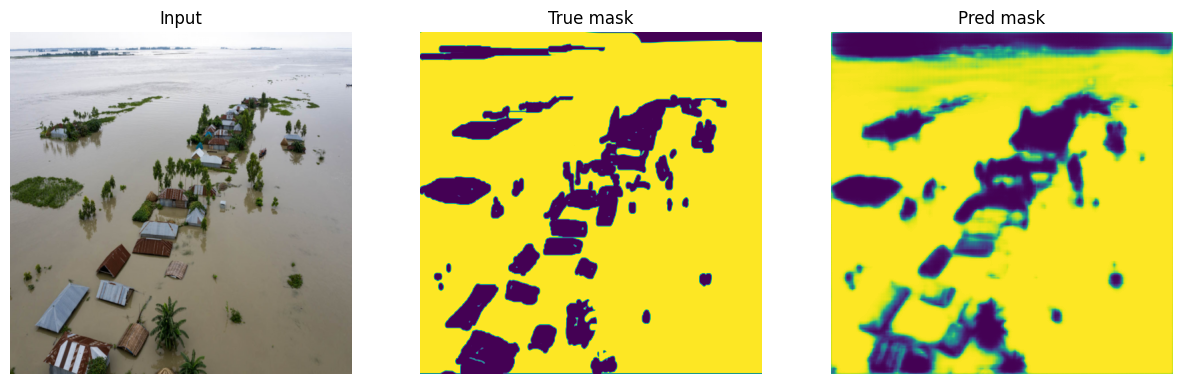

In [24]:
import random
from kemsekov_torch.train import load_checkpoint
import matplotlib.pyplot as plt

#load model and best saved checkpoint for it
model = torch.jit.load("runs/segmentation/model.pt")
model = load_checkpoint(model,"runs/segmentation",-1).eval().float().cpu()

inp,labels = test_dataset[random.randint(0,len(test_dataset)-1)]
with torch.no_grad():
    pred = (model(inp[None,:])*2).sigmoid()[0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(inp.permute(1,2,0))
plt.title("Input")
plt.axis('off')
for i in range(len(labels)):
    plt.subplot(1,3,2)
    plt.imshow(labels[i])
    plt.title("True mask")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pred[i])
    plt.axis('off')
    plt.title("Pred mask")
    plt.show()